In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import seaborn as sns
import os

In [2]:
FIG_PREFIX = 'dblp1000'

In [3]:
root_dir = '../result/dblp_small_1000_result'
root_best_dir = '../result/dblp_small_1000_best_red_result'
root_lpms_dir = '../result/dblp_small_1000_lpms_result'
root_free_dir = '../result/dblp_small_1000_free_result2S'
id_cols = ['name', 'num_threads', 'gram_size', 'selectivity', 'num_keys']

In [12]:
def build_stats_filename(row, reduced):
    name = row['name']
    if 'parallel' in name:
    # if '-' in name:
        name = name.split('-')[0]
    fields = [name, str(int(row['num_threads'])), str(int(row['gram_size'])), str(row['selectivity'] if row['selectivity'] > 0 else -1), 'stats.csv']
    if reduced is not None:
        fields.insert(-1, str(reduced))
    space_file = f"time_report_"
    if 'LPMS' in name:
        space_file += f"lpms_t{row['num_threads']}"
        space_file += '_determ' if 'DETER' in name else '_random'
    else:
        space_file += f"{name.lower()}_t{row['num_threads']}"
        if reduced is not None:
            space_file += f"_red{reduced/1000:g}"
        space_file += f"_c{row['selectivity']}"
        if 'FREE' in name:
            space_file += f"_n{row['gram_size']}"
    # max_num = -1
    if 'key_upper_bound' in row:
        space_file += f"_{row['key_upper_bound']}"
        fields.insert(-1, str(int(row['key_upper_bound'])))
    space_file += '.txt'
    return '_'.join(fields), space_file   

In [13]:
def get_compute_space(space_f, root_dir=root_dir):
    fullname = os.path.join(root_dir, space_f)
    try:
        with open(fullname, 'r') as file:
            for line in file:
                if 'Maximum resident set size (kbytes)' in line:
                    return int(line.strip().split(': ')[-1].strip())
    except:
        print(f'Error reading file {fullname}')
        pass
    return -1

In [14]:
def get_stats_df(row, reduced=None, root_dir=root_dir):
    fname, space_f = build_stats_filename(row, reduced)
    return pd.read_csv(os.path.join(root_dir, fname), sep='\t'), get_compute_space(space_f, root_dir)

In [15]:
def add_num_after_filter(df, reduced_list=None, root_dir=root_dir):
    new_cols = {
        'num_after_filter': [],
        'per_query_num_after_filter': [],
        'match_count': [],
        'compute_size': []
    }
    idx = 0
    reduced = None
    if reduced_list is not None:
        assert(reduced_list is None or len(reduced_list) == df.shape[0])
    for _, row in df.iterrows():
        if reduced_list is not None:
            reduced = reduced_list[idx]
            idx += 1
        detail_df, compute_size = get_stats_df(row, reduced=reduced, root_dir=root_dir)
        new_cols['num_after_filter'].append(detail_df['num_after_filter'].sum())
        new_cols['per_query_num_after_filter'].append(detail_df['num_after_filter'].mean())
        new_cols['match_count'].append(detail_df['count'].sum())
        new_cols['compute_size'].append(compute_size)
    return df.assign(**new_cols)

In [16]:
def build_result_df(root_dir, reduced):
    summary_path = os.path.join(root_dir, 'summary.csv')
    summary_df = pd.read_csv(summary_path)
    summary_df.ffill(inplace=True)
    summary_df['overall_match_time'] = summary_df['compile_time'] + summary_df['match_time']
    summary_df.rename(columns={'overall_time': 'overall_index_time', '    name': 'name'}, inplace=True)
    summary_df['overall_time'] = summary_df['overall_index_time'] + summary_df['overall_match_time']
    # code for getting end-to-end trimmed mean
    res = summary_df.sort_values('overall_time')
    gb = res.groupby(by=id_cols)
    if gb.count()['selection_time'].min() > 2:
        res = res.drop(gb.tail(1).index)
        res = res.drop(gb.head(1).index)
    res_df = res.groupby(by=id_cols, as_index=False).min(numeric_only=True).apply(lambda x: x)
    res_df = add_num_after_filter(res_df, reduced_list=reduced, root_dir=root_dir)
    return res_df

In [17]:
res_df1 = build_result_df(root_dir, None)
res_df1.describe()

,num_threads,gram_size,selectivity,num_keys,selection_time,build_time,overall_index_time,index_size,compile_time,match_time,overall_match_time,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size
count,24.0,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,2.400000e+01,24.000000,24.000000,24.000000,24.000000,2.400000e+01,24.000000,24.0,2.400000e+01
mean,16.0,3.375000,0.173333,2433.583333,878.172603,0.185922,878.444872,6.781235e+07,0.019740,20.854408,20.874148,899.319020,1.604036e+07,16040.361083,913841.0,6.573055e+05
std,0.0,2.299575,0.430224,2410.004491,2927.863354,0.380981,2927.796651,2.174876e+07,0.013454,12.665000,12.661325,2933.380684,4.868694e+07,48686.941487,0.0,1.138819e+06
min,16.0,-1.000000,-1.000000,343.000000,1.109770,-1.000000,1.315670,6.654400e+04,0.005700,15.076805,15.082505,18.481224,1.708837e+06,1708.837000,913841.0,1.596720e+05
25%,16.0,2.000000,0.100000,795.750000,1.122672,0.216208,1.356950,5.993386e+07,0.012421,16.848160,16.869816,18.608357,2.042022e+06,2042.021750,913841.0,2.752820e+05
50%,16.0,4.000000,0.150000,1738.000000,1.245275,0.247139,1.554895,7.448000e+07,0.013675,17.248528,17.268881,19.844294,3.838640e+06,3838.640000,913841.0,2.989100e+05
75%,16.0,6.000000,0.500000,2999.500000,1.547038,0.357217,1.957215,8.351107e+07,0.023771,18.970129,18.983913,20.958440,5.091482e+06,5091.482000,913841.0,3.155510e+05
max,16.0,6.000000,0.700000,9004.000000,12375.600000,0.517444,12375.700000,8.657650e+07,0.056887,78.003202,78.008997,12390.782505,2.391366e+08,239136.631000,913841.0,4.420300e+06


In [18]:
res_lpms_df = build_result_df(root_lpms_dir, None)
res_lpms_df.describe()

Error reading file ../result/dblp_small_1000_lpms_result/time_report_lpms_t16_determ_20.txt
Error reading file ../result/dblp_small_1000_lpms_result/time_report_lpms_t16_determ_50.txt
Error reading file ../result/dblp_small_1000_lpms_result/time_report_lpms_t16_determ_100.txt
Error reading file ../result/dblp_small_1000_lpms_result/time_report_lpms_t16_determ_150.txt
Error reading file ../result/dblp_small_1000_lpms_result/time_report_lpms_t16_determ_200.txt
Error reading file ../result/dblp_small_1000_lpms_result/time_report_lpms_t16_determ_500.txt
Error reading file ../result/dblp_small_1000_lpms_result/time_report_lpms_t16_determ_1000.txt
Error reading file ../result/dblp_small_1000_lpms_result/time_report_lpms_t16_random_20.txt
Error reading file ../result/dblp_small_1000_lpms_result/time_report_lpms_t16_random_50.txt
Error reading file ../result/dblp_small_1000_lpms_result/time_report_lpms_t16_random_100.txt
Error reading file ../result/dblp_small_1000_lpms_result/time_report_lpms

,num_threads,gram_size,selectivity,num_keys,key_upper_bound,num_queries,selection_time,build_time,overall_index_time,index_size,compile_time,match_time,overall_match_time,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size
count,13.0,13.0,13.0,13.000000,13.000000,13.0,13.000000,13.0,13.000000,1.300000e+01,13.000000,13.000000,13.000000,13.000000,1.300000e+01,13.000000,13.0,13.0
mean,16.0,-1.0,-1.0,223.615385,233.846154,1000.0,736.781263,-1.0,736.781263,1.601674e+07,0.005755,54.985275,54.991036,791.802436,1.467470e+08,146747.015231,913841.0,-1.0
std,0.0,0.0,0.0,258.972501,279.867185,0.0,2163.185953,0.0,2163.185953,1.732185e+07,0.000053,33.615825,33.615802,2170.240786,1.253180e+08,125317.975525,0.0,0.0
min,16.0,-1.0,-1.0,20.000000,20.000000,1000.0,2.312960,-1.0,2.312960,1.165400e+04,0.005683,17.184966,17.190836,22.480708,1.286096e+07,12860.964000,913841.0,-1.0
25%,16.0,-1.0,-1.0,50.000000,50.000000,1000.0,2.701140,-1.0,2.701140,2.950600e+04,0.005730,20.705395,20.711157,29.736717,1.892020e+07,18920.200000,913841.0,-1.0
50%,16.0,-1.0,-1.0,150.000000,150.000000,1000.0,42.502400,-1.0,42.502400,1.298897e+07,0.005760,46.717993,46.723679,136.563037,1.091812e+08,109181.182000,913841.0,-1.0
75%,16.0,-1.0,-1.0,200.000000,200.000000,1000.0,171.375000,-1.0,171.375000,3.402784e+07,0.005774,86.231466,86.237223,263.196523,2.678808e+08,267880.805000,913841.0,-1.0
max,16.0,-1.0,-1.0,929.000000,1000.000000,1000.0,7894.140000,-1.0,7894.140000,4.149863e+07,0.005870,96.625863,96.631623,7971.839256,2.996823e+08,299682.324000,913841.0,-1.0


In [19]:
res_free_df = build_result_df(root_free_dir, None)
res_free_df.describe()

,num_threads,gram_size,selectivity,num_keys,key_upper_bound,num_queries,selection_time,build_time,overall_index_time,index_size,compile_time,match_time,overall_match_time,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size
count,83.0,83.000000,83.000000,83.000000,83.000000,83.0,83.000000,83.000000,83.000000,8.300000e+01,83.000000,83.000000,83.000000,83.000000,8.300000e+01,83.000000,83.000000,83.000000
mean,16.0,4.530120,0.240964,237.180723,251.204819,0.0,1.489233,0.243130,1.732363,1.615629e+07,0.008272,62.800642,62.808914,64.541277,1.372371e+08,138868.960524,907450.987952,110383.084337
std,0.0,2.050207,0.228802,169.791058,159.644404,0.0,0.018859,0.090541,0.093088,1.678630e+07,0.000965,31.121011,31.120481,31.120774,9.958380e+07,100096.858936,58215.780335,45437.980513
min,16.0,2.000000,0.020000,87.000000,150.000000,0.0,1.437260,0.110595,1.574830,5.032880e+05,0.007201,20.599773,20.611459,22.288459,5.523436e+06,5523.436000,383470.000000,64968.000000
25%,16.0,2.000000,0.100000,123.500000,150.000000,0.0,1.478460,0.160754,1.655315,3.512328e+06,0.007840,31.363216,31.371141,33.069637,3.679213e+07,36792.127500,913841.000000,75336.000000
50%,16.0,4.000000,0.150000,150.000000,150.000000,0.0,1.489860,0.239775,1.720970,1.120131e+07,0.008033,65.534694,65.542828,67.147298,1.457489e+08,145748.919000,913841.000000,96496.000000
75%,16.0,6.000000,0.500000,500.000000,500.000000,0.0,1.502420,0.317605,1.810320,2.411530e+07,0.008449,93.063138,93.070893,94.841163,2.259676e+08,237768.780738,913841.000000,133962.000000
max,16.0,8.000000,0.700000,500.000000,500.000000,0.0,1.539580,0.431730,1.933740,6.677415e+07,0.011686,112.352044,112.359291,114.051511,2.909321e+08,290932.119000,913841.000000,242132.000000


In [20]:
res_best_df = build_result_df(root_best_dir, [50]*7 + [100]*7 + [200]*7 + [300]*3 + [500]*2 + [700]*2 + [850]*2)
res_best_df.describe()

,num_threads,gram_size,selectivity,num_keys,selection_time,build_time,overall_index_time,index_size,compile_time,match_time,overall_match_time,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size
count,30.0,30.0,30.000000,30.000000,30.000000,30.000000,30.000000,3.000000e+01,30.000000,30.000000,30.000000,30.000000,3.000000e+01,30.000000,30.0,3.000000e+01
mean,16.0,-1.0,0.348667,278.233333,3886.073400,0.013066,3886.085200,3.464453e+07,0.006098,22.568590,22.574689,3908.659889,3.860323e+07,38603.228467,913841.0,1.684501e+06
std,0.0,0.0,0.251968,99.075966,3314.620786,0.008005,3314.623143,1.624779e+07,0.000197,10.800989,10.800938,3309.366529,5.274900e+07,52749.001676,0.0,1.240990e+06
min,16.0,-1.0,0.050000,126.000000,423.002000,0.000749,423.003000,4.907064e+06,0.005821,14.553062,14.559052,480.616991,3.780455e+06,3780.455000,913841.0,3.201720e+05
25%,16.0,-1.0,0.120000,196.000000,961.209750,0.005550,961.225000,2.025533e+07,0.005937,15.495216,15.501386,980.216630,3.903342e+06,3903.342000,913841.0,6.164840e+05
50%,16.0,-1.0,0.200000,277.000000,2515.030000,0.012680,2515.050000,3.443162e+07,0.006093,18.253490,18.259400,2530.993174,5.784952e+06,5784.952000,913841.0,1.317032e+06
75%,16.0,-1.0,0.500000,350.750000,6186.062500,0.020195,6186.075000,4.948335e+07,0.006194,25.285240,25.291188,6204.242438,4.918159e+07,49181.594000,913841.0,2.670448e+06
max,16.0,-1.0,0.700000,447.000000,10224.200000,0.023685,10224.200000,5.445339e+07,0.006613,57.608163,57.613991,10239.343934,1.580963e+08,158096.269000,913841.0,3.699292e+06


In [21]:
res_df1.columns

Index(['name', 'num_threads', 'gram_size', 'selectivity', 'num_keys',
       'selection_time', 'build_time', 'overall_index_time', 'index_size',
       'compile_time', 'match_time', 'overall_match_time', 'overall_time',
       'num_after_filter', 'per_query_num_after_filter', 'match_count',
       'compute_size'],
      dtype='object')

In [22]:
res_df = pd.concat([res_df1, res_best_df, res_lpms_df, res_free_df], ignore_index=True)

In [23]:
# explore the distribution of number of keys and number
res_df['prop_error'] = (res_df['num_after_filter'] - res_df['match_count']) / res_df['num_after_filter']
res_df['precision'] = ( res_df['match_count']) / res_df['num_after_filter']
res_df['method'] = [name.split('-')[0] for name in res_df['name']]
new_res_df = res_df.loc[res_df.groupby(['num_after_filter', 'precision', 'num_keys']).gram_size.idxmin()].sort_values(by='num_keys')
new_groups = new_res_df.groupby(['method', 'gram_size'])

In [24]:
res_df[res_df.match_time == res_df.match_time.min()]

,name,num_threads,gram_size,selectivity,num_keys,selection_time,build_time,overall_index_time,index_size,compile_time,...,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size,key_upper_bound,num_queries,prop_error,precision,method
39,BEST-parallel,16,-1,0.2,447,6442.08,0.018978,6442.1,45603624,0.00599,...,6456.659052,5784952,5784.952,913841,1317032,NaN,NaN,0.842031,0.157969,BEST


In [32]:
name_map = {
    'BEST' : '\\best ',
    'FREE' : '\\free ',
    'FAST' : '\\lpms ',
    'LPMS' : '\\lpms '
}

def check_min_cell(row, col, format_out, curr_group):
    curr_str = ''
    if row[col] == curr_group[col].min():
        curr_str += '& \cellcolor{green!50}{'
        curr_str += format_out
        curr_str += '} '
    else:
        curr_str += f'& {format_out} '
    return curr_str

def check_max_cell(row, col, format_out, curr_group):
    curr_str = ''
    if row[col] == curr_group[col].max():
        curr_str += '& \cellcolor{yellow!50}{'
        curr_str += format_out
        curr_str += '} '
    else:
        curr_str += f'& {format_out} '
    return curr_str
summary_df = None

for up_lim in [150, 500, 1000, 2000, 3000, 4000, 5000]:
    curr_df = new_res_df[new_res_df['num_keys'] <= up_lim]
    curr_group = curr_df.sort_values(by=['precision', 'overall_time'], ascending=[False, True]).groupby(['method']).first()
    # curr_group = curr_df.loc[curr_df.groupby(['method']).precision.idxmax()].sort_values(by='precision', ascending=False)
    # print(curr_group)
    # curr_group['key_upper_bound'] = [up_lim]*curr_group.shape[0]
    curr_group = curr_group.sort_values(by='name')
    count = 0
    curr_row_count = curr_group.shape[0]
    for _, row in curr_group.iterrows():
        curr_str = ''
        count += 1;
        if count == 1:
            curr_str += '\multirow{'+str(curr_row_count)+'}{*}{\\bf{'+str(up_lim)+'}}'
        curr_str += f'& {name_map[row["name"][:4]]} '

        curr_str += check_min_cell(row, 'overall_match_time', f'{row["overall_match_time"]:.1f}', curr_group)
        curr_str += check_min_cell(row, 'overall_index_time', f'{row["overall_index_time"]:.0f}', curr_group)
        curr_str += check_min_cell(row, 'compute_size', f'{row["compute_size"]/1000000:.3f}', curr_group)
        curr_str += check_min_cell(row, 'index_size', f'{row["index_size"]/1000000:.3f}', curr_group)
        curr_str += check_max_cell(row, 'precision', f'{row["precision"]:.3f}', curr_group)
        print(curr_str, end='')
        if count < curr_row_count:
            print("\\\\")
        else:
            print("\\\\ \midrule")
#     app = []
#     for m in ['BEST', 'FREE', 'LPMS']:
#         if m not in curr_group.index:
#             app.append({'name': m, 
#                         'overall_index_time': 0,
#                         'index_size': 0,
#                         'compute_size': 0,
#                         'precision': 0})
#     for a in app:
#         curr_group = curr_group.append(a, ignore_index=True)

#     if summary_df is None:
#         summary_df = curr_group
#     else:
#         summary_df = pd.concat([summary_df, curr_group], ignore_index=True)
# summary_df['name'] = [ nm.split('-')[0] for n

\multirow{3}{*}{\bf{150}}& \best  & \cellcolor{green!50}{19.7} & 533 & 2.194 & \cellcolor{green!50}{33.433} & \cellcolor{yellow!50}{0.235} \\
& \free  & 25.3 & \cellcolor{green!50}{2} & 0.171 & 37.299 & 0.051 \\
& \lpms  & 19.8 & 3 & \cellcolor{green!50}{-0.000} & 34.028 & 0.048 \\ \midrule
\multirow{3}{*}{\bf{500}}& \best  & \cellcolor{green!50}{15.2} & 8762 & 2.670 & 54.306 & \cellcolor{yellow!50}{0.242} \\
& \free  & 20.6 & \cellcolor{green!50}{2} & 0.242 & 66.774 & 0.165 \\
& \lpms  & 17.7 & 6 & \cellcolor{green!50}{-0.000} & \cellcolor{green!50}{40.657} & 0.070 \\ \midrule
\multirow{3}{*}{\bf{1000}}& \best  & \cellcolor{green!50}{15.2} & 8762 & 2.670 & 54.306 & \cellcolor{yellow!50}{0.242} \\
& \free  & 18.7 & \cellcolor{green!50}{1} & \cellcolor{green!50}{0.287} & 75.354 & 0.219 \\
& \lpms  & 17.0 & 808 & 1.309 & \cellcolor{green!50}{41.499} & 0.071 \\ \midrule
\multirow{3}{*}{\bf{2000}}& \best  & \cellcolor{green!50}{15.2} & 8762 & 2.670 & 54.306 & 0.242 \\
& \free  & 17.4 & \ce

In [26]:
overall_df = None
df_by_lims = {}
lims = [150, 500, 1000, 2000, 3000, 4000, 5000]
for up_lim in lims:
    curr_df = new_res_df[new_res_df['num_keys'] <= up_lim]
    # print(curr_df.groupby(['method']).precision.idxmax())
    # curr_group = curr_df.loc[curr_df.groupby(['method']).precision.idxmax()].sort_values(by='precision', ascending=False)
    curr_group = curr_df.sort_values(by=['precision', 'overall_time'], ascending=[False, True]).groupby(['method']).first()
    curr_group['key_upper_bound'] = [up_lim]*curr_group.shape[0]
    app = []
    for m in ['BEST', 'FREE', 'LPMS']:
        if m not in curr_group.index:
            app.append({'name': m, 
                        'overall_index_time': 0,
                        'index_size': 0,
                        'compute_size': 0,
                        'precision': 0})
    for a in app:
        curr_group = curr_group.append(a, ignore_index=True)
    # print(curr_group)
    if overall_df is None:
        overall_df = curr_group
    else:
        overall_df = overall_df.append(curr_group, ignore_index=True)
    df_by_lims[up_lim] = curr_group
overall_df['name'] = [ nm.split('-')[0] for nm in overall_df['name'].to_list()]

In [27]:
overall_df

,name,num_threads,gram_size,selectivity,num_keys,selection_time,build_time,overall_index_time,index_size,compile_time,...,overall_match_time,overall_time,num_after_filter,per_query_num_after_filter,match_count,compute_size,key_upper_bound,num_queries,prop_error,precision
0,BEST,16,-1,0.50,150,532.54600,0.011743,532.55800,33433256,0.006376,...,19.669759,552.227759,3894299,3894.299,913841,2193748,150,NaN,0.765339,0.234661
1,FREE,16,2,0.70,150,1.49625,0.133885,1.63014,37298922,0.008543,...,25.290970,26.921110,17911489,17911.489,913841,171292,150,0.0,0.948980,0.051020
2,LPMS,16,-1,-1.00,150,2.70114,-1.000000,2.70114,34027844,0.005768,...,19.779568,22.480708,18920200,18920.200,913841,-1,150,1000.0,0.951700,0.048300
3,BEST,16,-1,0.50,363,8761.51000,0.023685,8761.53000,54306400,0.006200,...,15.157386,8776.687386,3780455,3780.455,913841,2670448,500,NaN,0.758272,0.241728
4,FREE,16,2,0.70,500,1.48879,0.188213,1.67700,66774154,0.011686,...,20.611459,22.288459,5523436,5523.436,913841,242132,500,0.0,0.834552,0.165448
5,LPMS,16,-1,-1.00,500,6.05392,-1.000000,6.05392,40657316,0.005817,...,17.725799,23.779719,13076749,13076.749,913841,-1,500,1000.0,0.930117,0.069883
6,BEST,16,-1,0.50,363,8761.51000,0.023685,8761.53000,54306400,0.006200,...,15.157386,8776.687386,3780455,3780.455,913841,2670448,1000,NaN,0.758272,0.241728
7,FREE,16,4,0.50,810,1.16911,0.237357,1.40646,75354446,0.013157,...,18.701772,20.108232,4171619,4171.619,913841,286524,1000,0.0,0.780939,0.219061
8,LPMS,16,-1,-1.00,929,807.67900,-1.000000,807.67900,41498628,0.005987,...,17.048382,824.727382,12860964,12860.964,913841,1308540,1000,1000.0,0.928945,0.071055
9,BEST,16,-1,0.50,363,8761.51000,0.023685,8761.53000,54306400,0.006200,...,15.157386,8776.687386,3780455,3780.455,913841,2670448,2000,NaN,0.758272,0.241728


In [28]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 22
SMALL_SMALL_SIZE = 13

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']
for col in ['precision', 'overall_index_time', 'index_size', 'compute_size']:
    # fig, ax = plt.subplots(figsize=(4,2.8))
    fig, ax = plt.subplots(figsize=(6,4.2))
        
    x = np.arange(len(lims))  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0
    for method, color in zip(['BEST', 'FREE', 'LPMS'], colors):
        curr = overall_df.loc[overall_df["name"] == method]#.sort_values('name')
        
        X = curr['key_upper_bound']
        
        # fig, ax = plt.subplots(layout='constrained')
        offset = width * multiplier - width
        Y = curr[col].to_numpy()
        if col == 'compute_size':
            rects = ax.bar(x + offset, Y, width, alpha=0.7, label=method, color=color)
        else:
            rects = ax.bar(x + offset, Y, width, alpha=0.7, color=color)
        multiplier += 1
        
    ylb = ' '.join([w.capitalize() for w in col.split('_')[-2:]])
    if col == 'overall_index_time':
        ax.set_yscale('log')
        ax.ticklabel_format(axis='x', scilimits=[-3,3])
        ylb += ' (log)'
    else:
        ax.ticklabel_format(scilimits=[-3,3])
    ax.set_ylabel(ylb)
    ax.set_xlabel('Max Num Index Keys')

    ax.set_xticks(ticks=x, labels=[f'{int(v)}' for v in lims])
    
    # fig.text(0.5, 0.04, 'Key Upper Bound', ha='center', va='center')
    if col == 'compute_size':
        plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
    plt.grid()
    plt.savefig(f'figs/{FIG_PREFIX}_{col}.pdf', bbox_inches='tight')
    plt.show()

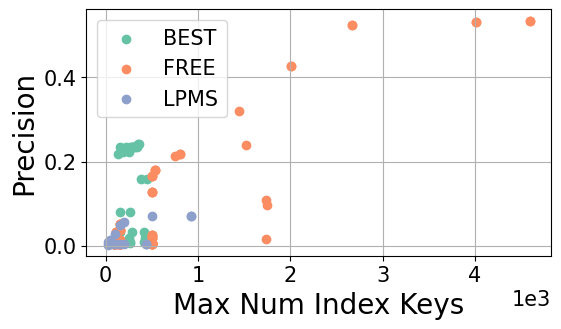

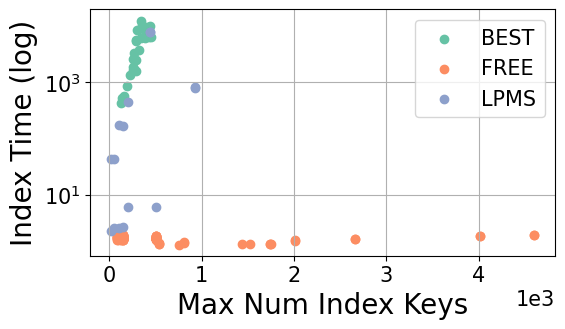

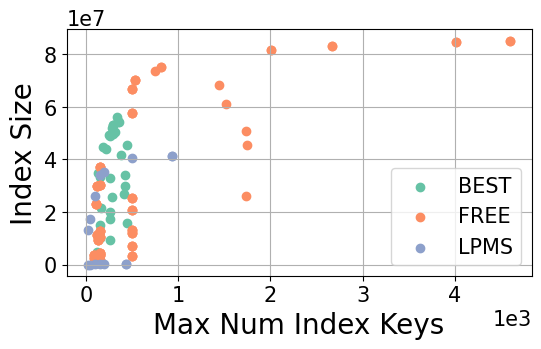

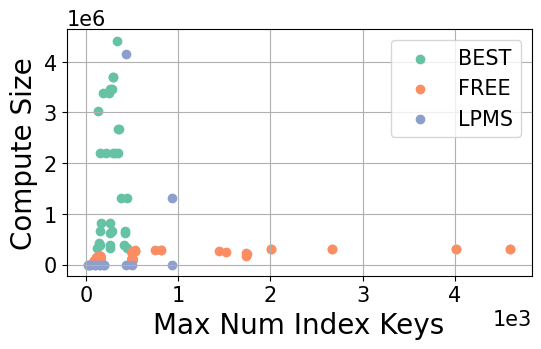

In [36]:
colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']
for col in ['precision', 'overall_index_time', 'index_size', 'compute_size']:
    # fig, ax = plt.subplots(figsize=(4,2.8))
    fig, ax = plt.subplots(figsize=(6,3.2))
    
    for method, color in zip(['BEST', 'FREE', 'LPMS'], colors):
        curr_all_df = res_df[(res_df["method"] == method) & (res_df["num_keys"] <= lims[-1])]
        ax.scatter(curr_all_df['num_keys'], curr_all_df[col], c=color, label=method)
        
    ylb = ' '.join([w.capitalize() for w in col.split('_')[-2:]])
    if col == 'overall_index_time':
        ax.set_yscale('log')
        ax.ticklabel_format(axis='x', scilimits=[-3,3])
        ylb += ' (log)'
    else:
        ax.ticklabel_format(scilimits=[-3,3])
    ax.set_ylabel(ylb)
    ax.set_xlabel('Max Num Index Keys')

    # ax.set_xticks(ticks=x, labels=[f'{int(v)}' for v in lims])
    
    # fig.text(0.5, 0.04, 'Key Upper Bound', ha='center', va='center')
    plt.legend(loc='best')
    plt.grid()
    plt.savefig(f'figs/{FIG_PREFIX}_scatter_{col}.pdf', bbox_inches='tight')
    plt.show()

In [ ]:
# colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']
# for col in ['precision', 'overall_index_time', 'index_size', 'compute_size']:
#     fig, ax = plt.subplots(figsize=(4,2.8))
        
#     x = np.array(lims)-150  # the label locations
#     width = 0.15 *1000 # the width of the bars
#     multiplier = 0
#     for method, color in zip(['BEST', 'FREE', 'LPMS'], colors):
#         curr = overall_df.loc[overall_df["name"] == method]#.sort_values('name')
        
#         X = curr['key_upper_bound']
        
#         # fig, ax = plt.subplots(layout='constrained')
#         prev = 0
#         offset = width * multiplier
#         Y = curr[col].to_numpy()
#         if col == 'compute_size':
#             rects = ax.bar(x + offset, Y, width, alpha=0.7, label=method, color=color)
#         else:
#             rects = ax.bar(x + offset, Y, width, alpha=0.7, color=color)

#         multiplier += 1

#         curr_all_df = res_df[(res_df["method"] == method) & (res_df["num_keys"] <= lims[-1])]
#         ax.scatter(curr_all_df['num_keys'], curr_all_df[col], c=color)
        
#     ylb = ' '.join([w.capitalize() for w in col.split('_')[-2:]])
#     if col == 'overall_index_time':
#         ax.set_yscale('log')
#         ax.ticklabel_format(axis='x', scilimits=[-3,3])
#         ylb += ' (log)'
#     else:
#         ax.ticklabel_format(scilimits=[-3,3])
#     ax.set_ylabel(ylb)
#     ax.set_xlabel('Key Upper Bound')

#     ax.set_xticks(ticks=lims)#, labels=[f'{int(v/1000)}k' for v in lims[1:]])
    
#     # fig.text(0.5, 0.04, 'Key Upper Bound', ha='center', va='center')
#     if col == 'compute_size':
#         plt.legend(loc='lower left', bbox_to_anchor=(1, 0))
#     plt.grid()
#     plt.savefig(f'figs/{FIG_PREFIX}_{col}.pdf', bbox_inches='tight')
#     plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20,4))

colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']
for (name, new_group), color in zip(new_groups, colors):
    print(name)
    new_group.loc[new_group["selectivity"] == -1, "selectivity"] = 0

    X = new_group['index_size']
    Y = new_group['precision']
    curr_lab = new_group['name'].to_list()[0].split('-')[0]
    if name[1] != -1:
        curr_lab += f' n={name[1]}'
    ax.plot(X, Y, c=color, label=curr_lab)
    ax.scatter(X, Y, marker='o', #label=curr_lab, 
               c=color,
               edgecolors='black',# alpha=new_group['selectivity'].to_list(), 
               #s=1000*new_group['selectivity'].to_numpy()
              )
    # for g, s, x, y in zip(new_group['gram_size'], new_group['selectivity'], X, Y):
    #     ax.annotate('(%s, %s)' % (g, s), xy=(x,y), textcoords='data') # <--
plt.gca().set_xscale("log")
ax.set_xlabel('Index Size')
ax.set_ylabel('Precision')

# ax.set_xlim([0, 5000])
plt.legend()
plt.savefig(f'figs/{FIG_PREFIX}_constrSize_prec.pdf', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20,4))

colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']
for (name, new_group), color in zip(new_groups, colors):
    print(name)
    new_group.loc[new_group["selectivity"] == -1, "selectivity"] = 0

    X = new_group['overall_index_time']
    Y = new_group['precision']
    curr_lab = new_group['name'].to_list()[0].split('-')[0]
    if name[1] != -1:
        curr_lab += f' n={name[1]}'
    ax.plot(X, Y, c=color, label=curr_lab)
    ax.scatter(X, Y, marker='o', #label=curr_lab, 
               c=color,
               edgecolors='black',# alpha=new_group['selectivity'].to_list(), 
               #s=1000*new_group['selectivity'].to_numpy()
              )
    # for g, s, x, y in zip(new_group['gram_size'], new_group['selectivity'], X, Y):
    #     ax.annotate('(%s, %s)' % (g, s), xy=(x,y), textcoords='data') # <--
plt.gca().set_xscale("log")
ax.set_xlabel('Index Construction Time')
ax.set_ylabel('Precision')

# ax.set_xlim([0, 5000])
plt.legend()
plt.savefig(f'figs/{FIG_PREFIX}_constrTime_prec.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# explore the distribution of number of keys and number

groups = res_df.groupby('name')
colors = ['#7fc97f','#beaed4','#fdc086']
ax = plt.subplot()
for (name, group), color in zip(groups, colors):
    ax.scatter(group['num_keys'], group['num_after_filter'], c=color, label=name)
ax.set_xlabel('num_keys')
ax.set_ylabel('num_after_filter')

# inset Axes....
x1, x2, y1, y2 = 0,5000, 0, 30000000  # subregion of the original image
axins = ax.inset_axes(
    [0.3, 0.4, 0.67, 0.47],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
for (name, group), color in zip(groups, colors):
    axins.scatter(group['num_keys'], group['num_after_filter'], c=color, label=name)
# axins.scatter(res_df['num_keys'], res_df['num_after_filter'])
plt.legend()
ax.indicate_inset_zoom(axins, edgecolor="black")

plt.show()

In [ ]:
# get their configurations
curr_examine = res_df[(res_df['num_keys'] <= x2) & (res_df['num_after_filter'] <= y2)]
trimed = curr_examine.loc[curr_examine.groupby('num_after_filter').gram_size.idxmin()]
trimed = trimed.sort_values(by='num_after_filter')

In [ ]:
trimed

In [ ]:
groups = res_df.groupby('name')
colors = ['#7fc97f','#beaed4','#fdc086']
ax = plt.subplot()
ax.set_ylim([-0.01, 0.7])
for (name, group), color in zip(groups, colors):
    ax.scatter(group['num_keys'], group['precision'], c=color, label=name)
ax.set_xlabel('num_keys')
ax.set_ylabel('Precision')

# print( res_df['match_count'])
# print(res_df['num_after_filter'])
# print(res_df['prop_error'])
# print((239136631-913841)/239136631)

# inset Axes....
x1, x2, y1, y2 = 0,5500, 0.17, 0.6  # subregion of the original image
axins = ax.inset_axes(
    [0.37, 0.5, 0.6, 0.47],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
for (name, group), color in zip(groups, colors):
    axins.scatter(group['num_keys'], group['precision'], c=color, label=name)
# axins.scatter(res_df['num_keys'], res_df['num_after_filter'])
plt.legend(loc='center right')
ax.indicate_inset_zoom(axins, edgecolor="black")

plt.show()

In [ ]:
# get their configurations
curr_examine = res_df[(res_df['num_keys'] <= x2) & (res_df['precision']>= y1)]
trimed = curr_examine.loc[curr_examine.groupby('num_after_filter').gram_size.idxmin()]
sorted_df = trimed.sort_values(by='precision')

In [ ]:
trimed

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))
new_res_df = res_df.loc[res_df.groupby(['num_after_filter', 'num_keys']).gram_size.idxmin()].sort_values(by='num_keys')

new_groups = new_res_df.groupby(['name', 'gram_size'])
colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']
for (name, new_group), color in zip(new_groups, colors):
    print(name)
    new_group.loc[new_group["selectivity"] == -1, "selectivity"] = 1

    X = new_group['num_keys']
    Y = new_group['precision']
    curr_lab = new_group['name'].to_list()[0].split('-')[0]
    if name[1] != -1:
        curr_lab += f' n={name[1]}'
    ax.plot(X, Y, c=color)
    ax.scatter(X, Y, marker='o', label=curr_lab, c=color,
               edgecolors='black',# alpha=new_group['selectivity'].to_list(), 
               s=1000*new_group['selectivity'].to_numpy())
    # for g, s, x, y in zip(new_group['gram_size'], new_group['selectivity'], X, Y):
    #     ax.annotate('(%s, %s)' % (g, s), xy=(x,y), textcoords='data') # <--

ax.set_xlabel('num_keys')
ax.set_ylabel('precision')

ax.set_xlim([0, 5000])
plt.legend(loc="lower right", labelspacing=2)
plt.savefig(f'figs/{FIG_PREFIX}_numkey_prec.pdf', bbox_inches='tight')
plt.show()

In [ ]:
new_res_df[new_res_df['num_keys'] < 5000].sort_values(by='num_after_filter', ascending=True)

In [ ]:
data = np.sort(new_res_df['num_keys'].to_numpy())
fig, ax = plt.subplots(figsize=(10, 1))
ax.scatter(data, [10] * len(data))

In [ ]:
# decide the split points
def pairwise_difference(lst):
    differences = []
    prec_diffs = []
    for i in range(len(lst) - 1):
        prec_diffs.append((lst[i + 1] - lst[i])/lst[i])
        differences.append(lst[i + 1] - lst[i])
    return differences, prec_diffs
diffs, prec_diffs = pairwise_difference(data)
idxs = np.argsort(diffs)
prec_idxs = np.argsort(prec_diffs)
print(idxs)

In [ ]:
fig, ax = plt.subplots(figsize=(30, 1))
ax.scatter(data, [10] * len(data))
bins = [np.min(data)-1]
for idx in prec_idxs[-9:]:
    print(f'idx[{idx}], between {data[idx]} and {data[idx+1]}')
    curr_x = (data[idx] + data[idx + 1])/2
    bins.append(curr_x)
    ax.axvline(x=curr_x, color='red')
bins = np.sort(bins)
bins = np.append(bins, int(np.max(data)*1.01))

In [ ]:
fig, ax = plt.subplots(figsize=(10, 1))
ax.scatter(data, [10] * len(data))
ax.set_xlim([0, 10000])

for idx in prec_idxs[-9:]:
    if data[idx] < 10000:
        print(f'idx[{idx}], between {data[idx]} and {data[idx+1]} at {(data[idx] + data[idx + 1])/2}')
        curr_x = (data[idx] + data[idx + 1])/2
        ax.axvline(x=curr_x, color='red')

In [ ]:
print(bins)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(data, bins=bins, edgecolor='black', alpha=0.5)
print(np.log(bins))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.gca().set_xscale("log")
ax.set_xticks(bins)
ax.set_xticklabels([int(b) for b in bins], rotation=45)

ax2 = ax.twinx()

for (name, new_group), color in zip(new_groups, colors):
    new_group.loc[new_group["selectivity"] == -1, "selectivity"] = 1

    X = new_group['num_keys']
    Y = new_group['precision']
    ax2.plot(X, Y, c=color)
    curr_lab = new_group['name'].to_list()[0].split('-')[0]
    if name[1] != -1:
        curr_lab += f' n={name[1]}'
    sc = ax2.scatter(X, Y, marker='o', label=curr_lab, c=color,
               edgecolors='black', #alpha=new_group['selectivity'].to_list(), 
               s=1000*new_group['selectivity'].to_numpy())
    if name[0] == 'FREE-parallel':
        labs = (new_group['selectivity'].unique())
        labs = np.sort(labs)
        handles, labels = sc.legend_elements(prop="sizes", alpha=0.4,num=4)     
        # labels = new_group['selectivity'].unique()    
        # legend = ax.legend(handles, [" " , "Selectivity\nThreshold"," " ,  " "], title="Size")
        # ax.legend(*sc.legend_elements("sizes", num=4, alpha=0.5), loc='center right')

    # for g, s, x, y in zip(new_group['gram_size'], new_group['selectivity'], X, Y):
    #     ax2.annotate('(%s, %s)' % (g, s), xy=(x,y), textcoords='data') # <--
ax2.set_ylabel('Precision')
ax.set_ylabel('Index Count')
ax.set_xlabel('num_keys')
plt.legend(labelspacing=2)
plt.savefig(f'figs/{FIG_PREFIX}_numkey_prec_hist.pdf', bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(data, bins=bins, edgecolor='black');
# plt.gca().set_xscale("log")
ax2 = ax.twinx()

for (name, new_group), color in zip(new_groups, colors):
    new_group.loc[new_group["selectivity"] == -1, "selectivity"] = 1
    if name == 'FREE-parallel':
        curr_new_group = new_group[new_group['gram_size'] == 4]
    else:
        curr_new_group = new_group
    X = curr_new_group['num_keys']
    Y = curr_new_group['precision']
    ax2.plot(X, Y, c=color)
    ax2.scatter(X, Y, marker='o', label=curr_new_group['name'].to_list()[0], c=color,
               edgecolors='black', #alpha=new_group['selectivity'].to_list(), 
               s=1000*curr_new_group['selectivity'].to_numpy())
    for g, s, x, y in zip(curr_new_group['gram_size'], curr_new_group['selectivity'], X, Y):
        ax2.annotate('(%s, %s)' % (g, s), xy=(x,y), textcoords='data') # <--
ax2.set_ylabel('precision')
ax.set_ylabel('count')
ax.set_xlabel('num_keys')
ax.set_xlim([0, 6000])
plt.legend(labelspacing=2)

In [ ]:
# bin them by number of 
BIN_NUM = 10
new_res_df.hist(column='num_keys', bins=BIN_NUM)
heights, bins = np.histogram(data, bins=BIN_NUM)

In [ ]:
_, bins = np.histogram(np.log10(data + 1), bins=BIN_NUM)
plt.hist(data, bins=10**bins);
plt.gca().set_xscale("log")

In [ ]:
edges = 10**bins
prev = 0
for b in edges:
    print(new_res_df[(new_res_df['num_keys'] < b) & (new_res_df['num_keys'] >= prev)].sort_values(by='num_after_filter', ascending=True)[['name', 'num_keys', 'selection_time', 'num_after_filter']])
    prev = b
print([int(e) for e in edges])

In [ ]:
sns.histplot(new_res_df['num_keys'], bins=BIN_NUM, log_scale=True)

In [ ]:
prev = 0
for b in bins:
    print(new_res_df[(new_res_df['num_keys'] < b) & (new_res_df['num_keys'] >= prev)].sort_values(by='num_after_filter', ascending=True))
    prev = b

In [ ]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))
x = new_res_df['num_keys'].to_numpy()
n, bins, patches = plt.hist(x, histedges_equalN(x, 20))

In [ ]:
prev = 0
for b in bins:
    print(new_res_df[(new_res_df['num_keys'] < b) & (new_res_df['num_keys'] >= prev)].sort_values(by='num_after_filter', ascending=True))
    prev = b

In [ ]:
best_df = res_df[res_df['name'].str.contains('BEST')]

In [ ]:
free_df = res_df[(res_df['name'] == 'FREE') | (res_df['name'] == 'FREE-parallel')]

In [ ]:
# free with c = 0.1, plot false positive rate against gramsize 
# free_df = res_df[(res_df['name'] == 'FREE') | (res_df['name'] == 'FREE-parallel')]
temp_free = free_df[free_df['selectivity'] == 0.1]

In [ ]:
# gram size vs accuracy
temp = temp_free[temp_free['num_threads'] == 1]
ax = plt.subplot()
x = temp['gram_size']
y = (temp['num_after_filter'] - temp['match_count']) / temp['num_after_filter']
ax.plot(x, y) 
plt.xlabel('Max Gram Size')
plt.ylabel('False Positive Rate')
plt.show()

In [ ]:
# gram size vs index size; gram size vs index build time
fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios': [2, 1]}, sharex=True)

colors = ['#66c2a5','#fc8d62','#8da0cb']

temp = temp_free[temp_free['num_threads'] == 1]
x = temp['gram_size']
y_1 = temp['overall_index_time']
y_1_1 = temp['selection_time']
y_1_2 = temp['build_time']

y_2 = temp['num_keys']

axs[0].stackplot(x, y_1_1, y_1_2, labels=[
    'Gram Selection', 'Posting Lists Filling' #, 'Overall Index Construction'
],
    colors=colors[:-1])

# axs[0].plot(x, y_1, label='Overall Index Construction') 
# axs[0].plot(x, y_1_1, label='Gram Selection') 
# axs[0].plot(x, y_1_2, label='Posting Lists Filling') 
axs[0].set_ylabel('Time (s)')
axs[0].legend(loc='upper left')

axs[1].plot(x, y_2, marker='o', c=colors[-1])
axs[1].set_ylabel('Num Selected')

plt.xlabel('Max Gram Size')
plt.savefig(f'figs/{FIG_PREFIX}free_n_vs_index-time_num-keys.pdf', bbox_inches='tight')

plt.show()

In [ ]:
# thread vs. build time; label by gram size
ax = plt.subplot()
seq_colors = sns.color_palette("flare")#, as_cmap=True)
for i, gram_size in enumerate(temp_free['gram_size'].unique()):
    temp = temp_free[temp_free['gram_size'] == gram_size]
    x = temp['num_threads']
    y = temp['overall_index_time']
    ax.plot(x, y, label='FREE max {}-grams'.format(int(gram_size)), marker='o', color=seq_colors[i]) 
# ax.set_facecolor('gainsboro')
plt.xlabel('Number of Threads')
plt.ylabel('Index Building Time (s)')
plt.legend() 
plt.savefig(f'figs/{FIG_PREFIX}free_thread_vs_index-time.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# thread vs. build time; label by gram size
# temp_best = best_df[best_df['selectivity'] == 0.05]
# print(temp_best)
ax = plt.subplot()
seq_colors = sns.color_palette("crest")#, n_colors=11)#, as_cmap=True)
# for i, sel in enumerate(best_df['selectivity'].unique()):
for i, sel in enumerate([0.01, 0.05,0.1, 0.2]):
    temp = best_df[best_df['selectivity'] == sel]
    x = temp['num_threads']
    y = temp['overall_index_time']
    ax.plot(x, y, label='BEST c <= {}'.format(sel), marker='o', color=seq_colors[i]) 
# ax.set_facecolor('gainsboro')
plt.xlabel('Number of Threads')
plt.ylabel('Index Building Time (s)')
plt.legend() 
plt.savefig(f'figs/{FIG_PREFIX}_best_thread_vs_index-time.pdf', bbox_inches='tight')
plt.show()